In [1]:
# Main library: https://square.github.io/pysurvival/index.html
#----------------------------Reproducible------------------------------------------
import numpy as np
import random as rn
import pandas as pd
import gc
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
rn.seed(seed)

#----------------------------Reproducible------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import display_loss_values
from pysurvival.utils.display import compare_to_actual

from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt

import heapq
import seaborn as sns

In [2]:
def csv_read(p_path):
    pd_data=pd.read_csv(p_path, sep=',')
    column_names=pd_data.columns.values.tolist()
    print(column_names)
    return pd_data,column_names

def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe
    gc.collect()

In [3]:
data,column_names=csv_read('./data/survival_data_filtered_3.csv')

['NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NACCNINR', 'INRELTO', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG1', 'NACCSTYR', 'NACCTIYR', 'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE', 'CDRSUM', 'COMPORT', 'CDRLANG', 'NPIQINF', 'DEL', 'DELSEV', 'HALL', 'HALLSEV', 'AGIT', 'AGITSEV', 'DEPD', 'ANX', 'ANXSEV', 'ELAT', 'ELATSEV', 'APA', 'APASEV', 'DISN', 'DISNSEV', 'IRR', 'IRRSEV', 'MOT', 'MOTSEV', 'NITE', 'APP', 'APPSEV', 'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP', 'EVENTS', 'PAYATTN', 'REMDATES', 'TRAVEL', 'DECSUB', 'DECIN', 'COGMEM', 'COGJUDG', 'COGLANG', 'COGVIS', 'COGATTN', 'COGFLUC', 'COGOTHR', 'NACCCOGF', 'COGMODE', 'DECAGE', 'BEAPATHY', 'BEDEP', 'BEVHALL', 'BEAHALL', 'BEDEL', 'BEDISIN', 'BEIRRIT', 'BEAGIT',

In [4]:
data

,NACCREAS,NACCREFR,BIRTHMO,BIRTHYR,SEX,HISPANIC,HISPOR,RACE,RACESEC,RACETER,...,NPBNKB,NACCFORM,NACCPARA,NACCCSFP,NPBNKF,NPFAUT,NACCDAGE,NACCINT,SurvivalTime,Event
0,1,2,4,1926,2,0,88,1,88,88,...,0,1,1,1,0,0,89,43,1787,True
1,2,2,12,1939,2,0,88,1,88,88,...,1,1,1,0,0,0,75,37,2151,False
2,1,2,3,1963,1,0,88,1,88,88,...,1,1,1,0,0,0,53,10,490,False
3,2,2,7,1952,1,0,88,1,88,88,...,1,1,1,0,0,0,61,19,434,True
4,1,8,7,1927,1,0,88,1,3,88,...,1,1,1,0,0,0,91,9,3945,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2,2,4,1927,2,0,88,1,88,88,...,0,1,1,0,0,0,88,60,644,True
511,1,2,12,1948,2,0,88,1,88,88,...,1,0,1,0,0,0,67,4,0,False
512,1,1,3,1945,1,0,88,1,88,88,...,1,1,1,1,0,9,72,23,1238,False
513,2,2,7,1940,1,0,88,1,88,88,...,0,1,1,0,0,0,76,9,939,True


In [5]:
Events=np.array(data.loc[:,'Event'])
print("%.2f%% samples are right censored in whole data." % (np.sum(~Events) * 100. / len(Events)))

49.71% samples are right censored in whole data.


In [ ]:
X=data.loc[:,'NACCREAS':'NACCINT']
y_=data.loc[:,'SurvivalTime':'Event']
y=np.array([(y__[1],y__[0]) for y__ in np.array(y_)], dtype=[('Event', 'bool'), ('SurvivalTime', '<f8')])

models=[]
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
seed_num=5
epoch_num=2000

for seed_i in np.arange(seed_num):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=seed_i)

    time_train=y_train['SurvivalTime']
    event_train=y_train['Event']
    time_test=y_test['SurvivalTime']
    event_test=y_test['Event']

    # Building the model
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_train, time_train, event_train, num_epochs = epoch_num,lr=1e-4, init_method='glorot_uniform')

    models.append(nonlinear_coxph)

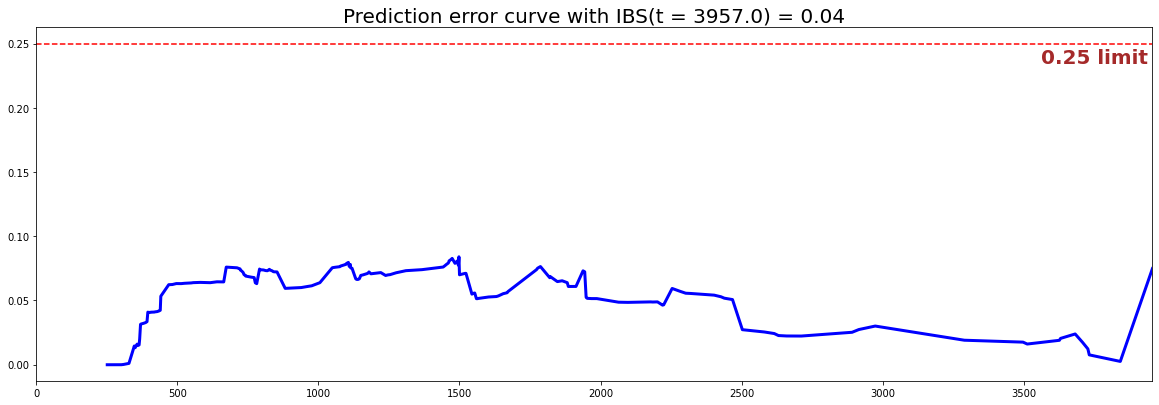

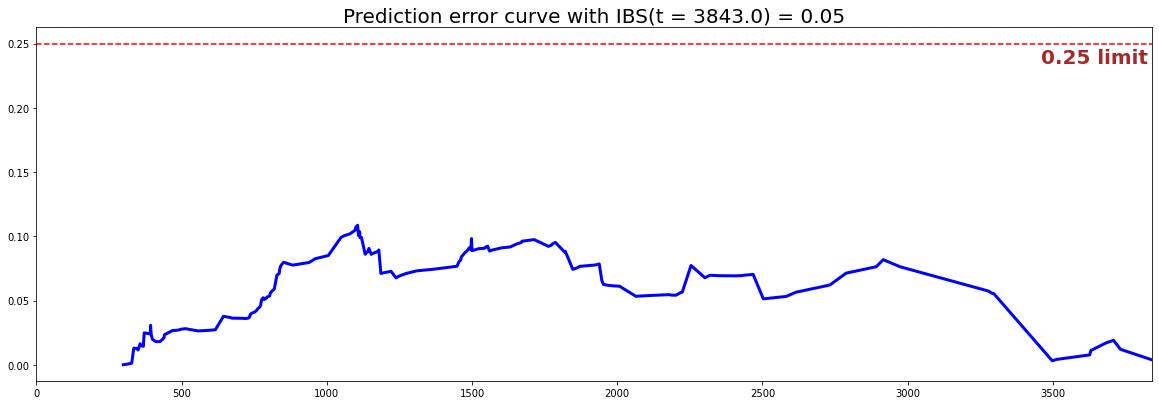

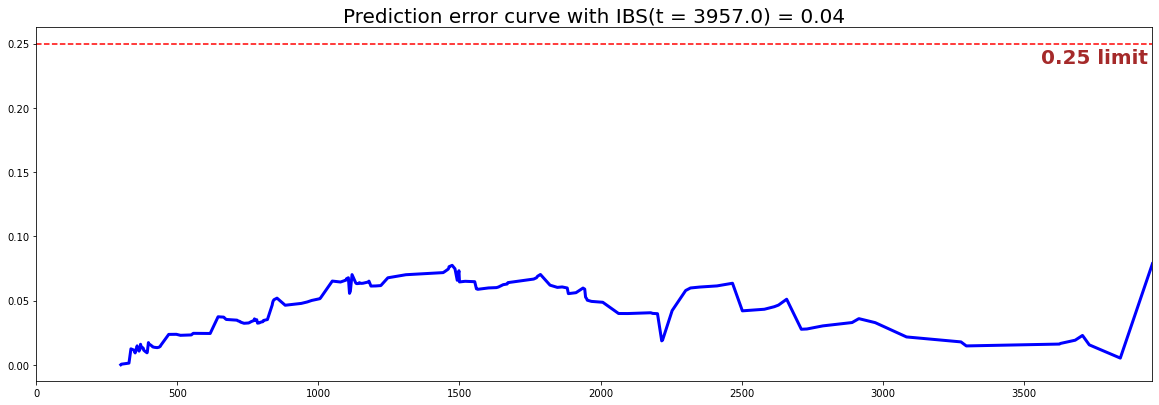

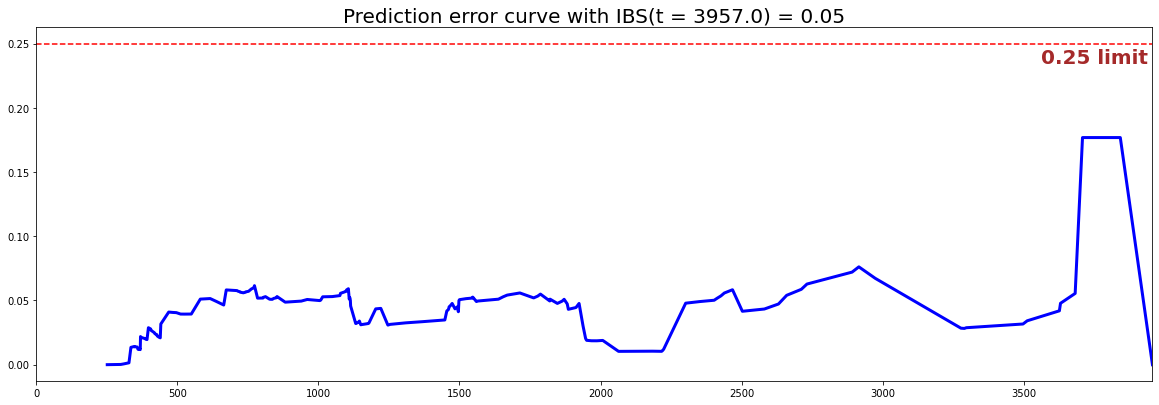

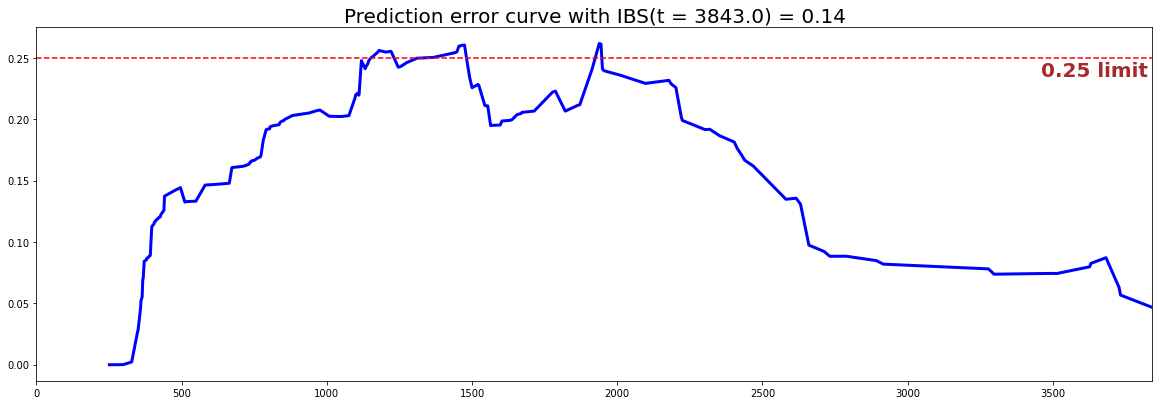

In [7]:
Loss_list=[]
C_index_list=[]
IBS_list=[]

for seed_i in np.arange(seed_num):
    model_used=models[seed_i]
    Loss_list.append(model_used.loss_values)
    
    # Model Performances
    c_index = concordance_index(model_used, X_test, time_test, event_test) #0.81
    #print('C-index: {:.2f}'.format(c_index))

    ibs = integrated_brier_score(model_used, X_test, time_test, event_test, t_max=None, figure_size=(20, 6.5) )
    #print('IBS: {:.2f}'.format(ibs))

    C_index_list.append(c_index)
    IBS_list.append(ibs)

In [8]:
p_path="./performance_CI.csv"
write_to_csv(np.array(C_index_list).reshape(1,np.array(C_index_list).shape[0]),p_path)
print(C_index_list)
print(np.mean(C_index_list))
print(np.std(C_index_list))

p_path="./performance_IBS.csv"
write_to_csv(np.array(IBS_list).reshape(1,np.array(IBS_list).shape[0]),p_path)
print(IBS_list)
print(np.mean(IBS_list))
print(np.std(IBS_list))

[0.9158335632327708, 0.905800403677142, 0.9372479464498813, 0.934558391614864, 0.7374900554584616]
0.8861860720866239
0.07526140764843242
[0.041906186476388343, 0.05367408469721112, 0.03720560090349611, 0.04601465643177768, 0.14261682536377676]
0.06428347077453
0.039538277607768214


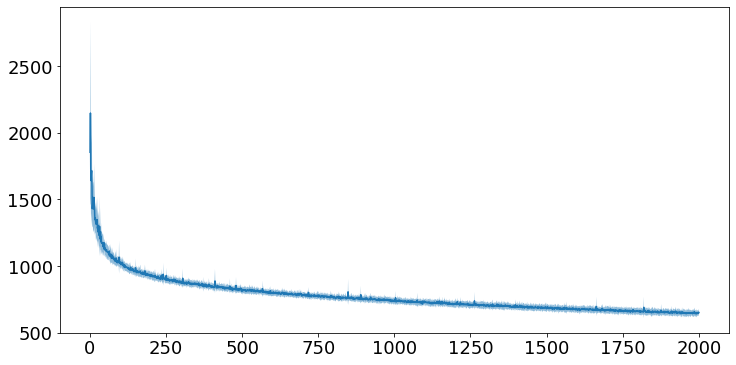

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
Loss_list_mean=np.mean(np.array(Loss_list),axis=0)
Loss_list_std=np.std(np.array(Loss_list),axis=0)

max_loss=int(np.max(Loss_list_mean))+1
min_loss=int(np.min(Loss_list_mean))
step=int(max_loss/5)

ax.plot(np.arange(epoch_num)+1, Loss_list_mean, '-')
ax.fill_between(np.arange(epoch_num)+1, Loss_list_mean - Loss_list_std, Loss_list_mean + Loss_list_std, alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

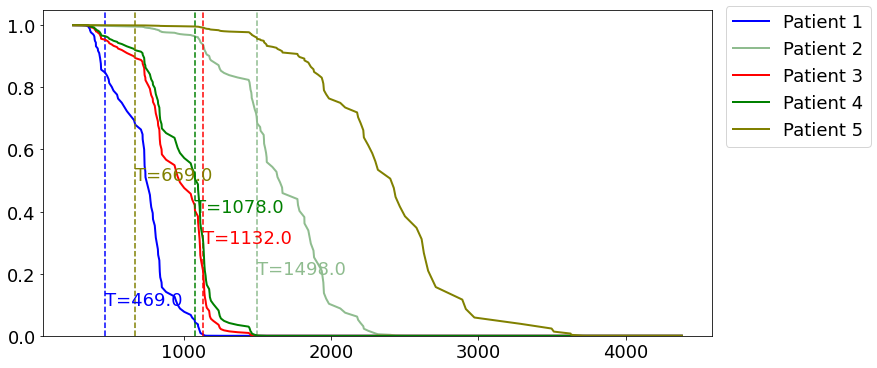

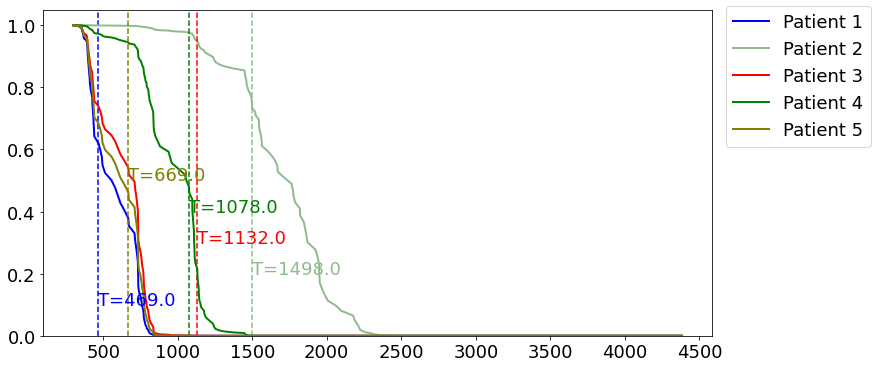

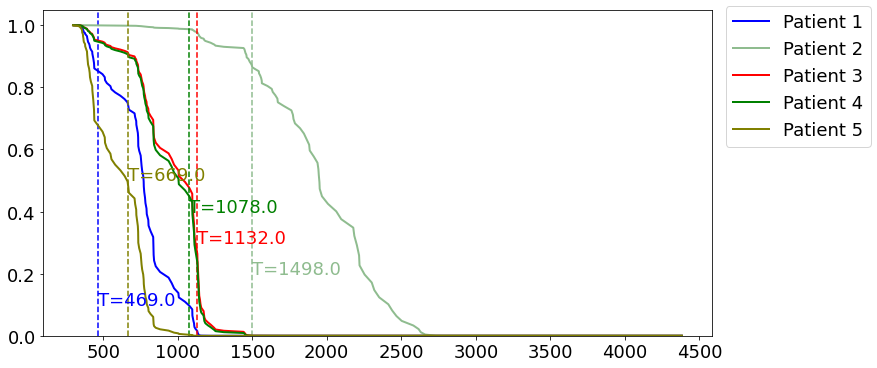

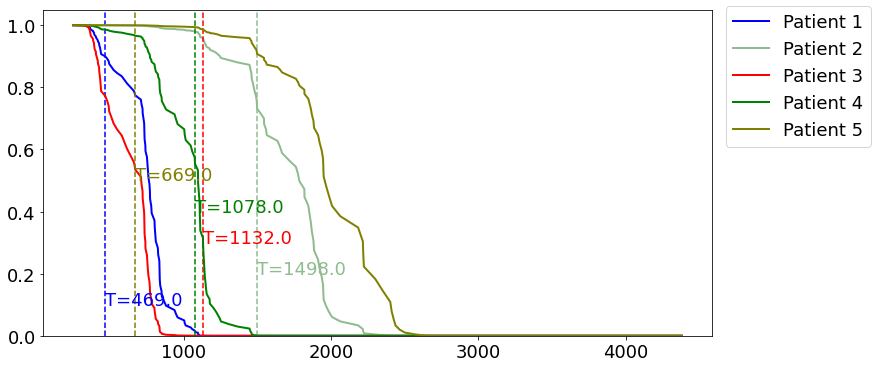

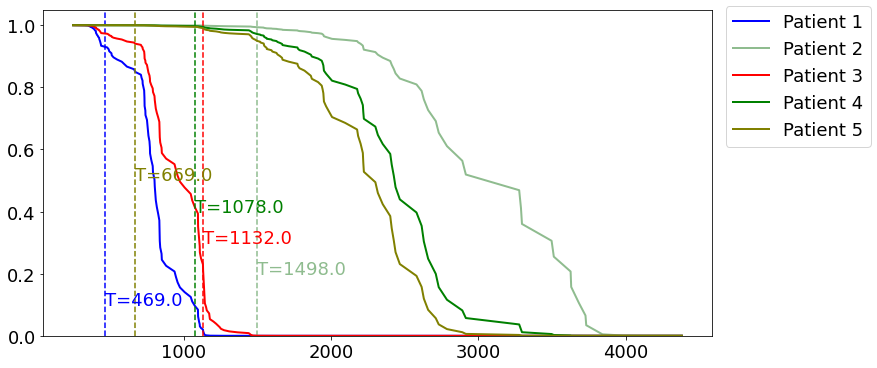

In [10]:
cs=['blue','darkseagreen','red','green','olive','cyan','tan','silver','purple','fuchsia','chocolate','darkcyan','aqua','pink','orange','bisque','lightsteelblue']

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k_list = np.random.choice( choices, 5,replace=False)

for seed_i in np.arange(seed_num):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Saving the time of event
    for i in np.arange(len(k_list)):
        k=k_list[i]
        t = time_test[k]

        # Computing the Survival function for all times t
        predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

        # Displaying the functions
        plt.plot(models[seed_i].times, predicted, color=cs[i], label='Patient '+str(i+1), lw=2)
    
        # Actual time
        plt.axvline(x=t, color=cs[i], ls ='--')
        ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, (0.1+i/10)), fontsize=18,color=cs[i])

    plt.legend(loc=[1.02,0.58],fontsize=18, ncol=1)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

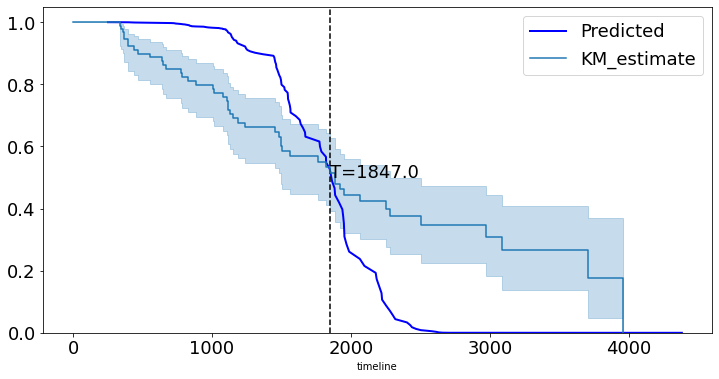

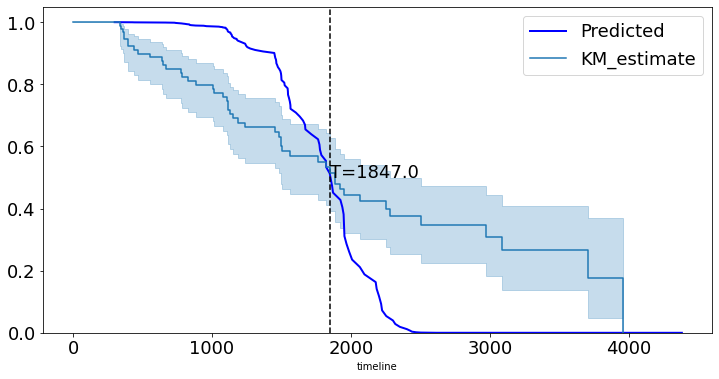

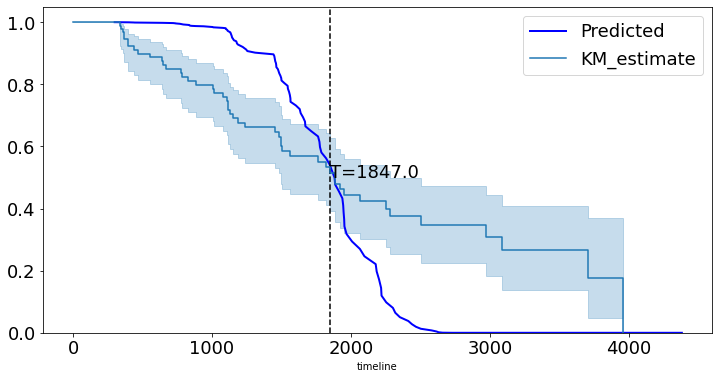

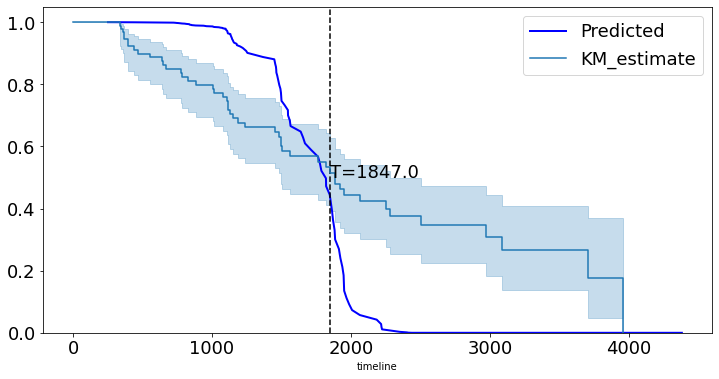

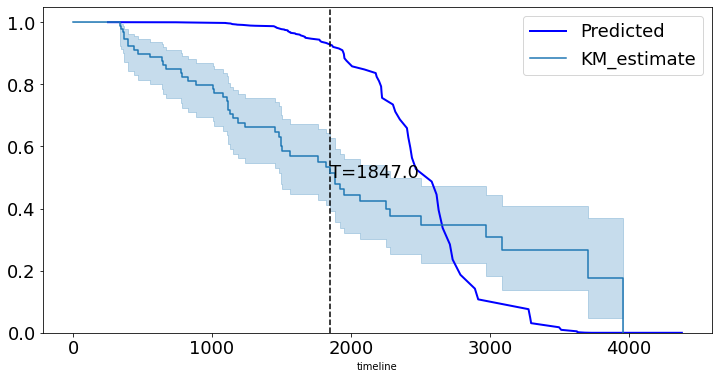

In [11]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]
    
for seed_i in np.arange(seed_num):
    
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Saving the time of event
    t = time_test[k]

    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()

    # Displaying the functions
    plt.plot(models[seed_i].times, predicted, color='blue', label='Predicted', lw=2)

    # Actual time
    plt.axvline(x=t, color='black', ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

    kmf.fit(time_test, event_observed=event_test)
    ax = kmf.plot_survival_function(ax=ax)

    # Show everything
    plt.legend(fontsize=18)
    plt.ylim(0, 1.05)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [12]:
# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((event_test==1.)&(time_test>=1)).flatten()
k = np.random.choice(choices, 1)[0]

# Saving the time of event
t = time_test[k]

predicted_list=[]
time_set={'Nan'}

for seed_i in np.arange(seed_num):
    # Computing the Survival function for all times t
    predicted = models[seed_i].predict_survival(X_test.values[k, :]).flatten()
    time=models[seed_i].times

    predicted_list.append(dict(zip(time,predicted)))
    time_set.update(set(time))

average_time_predicted_dict={}
for time_set_i in time_set:
    predicted_value=[]
    for seed_i in np.arange(seed_num):
        if time_set_i in predicted_list[seed_i].keys():
            predicted_value.append(predicted_list[seed_i][time_set_i])
    if len(predicted_value)>0:
        average_time_predicted_dict[time_set_i]=[np.mean(predicted_value),np.std(predicted_value)]
        
average_time_predicted={}
for i in sorted (average_time_predicted_dict.keys()) : 
    average_time_predicted[i]=average_time_predicted_dict[i]

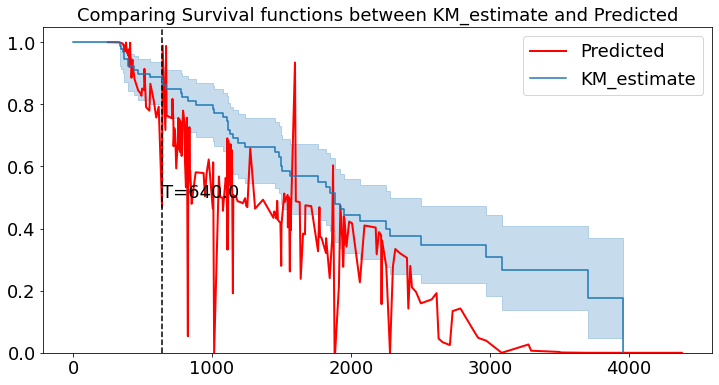

In [13]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(12, 6))

# Displaying the functions
plt.plot(list(average_time_predicted.keys()), np.array(list(average_time_predicted.values()))[:,0], color='red', label='Predicted', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=18)

kmf.fit(time_test, event_observed=event_test)
ax = kmf.plot_survival_function(ax=ax)

# Show everything
title = "Comparing Survival functions between KM_estimate and Predicted"
plt.legend(fontsize=18)
plt.title(title, fontsize=18)
plt.ylim(0, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("",fontsize=18)
plt.show()

In [14]:
models[0].model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=322, out_features=150, bias=True)
    (1): BentIdentity()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [15]:
feature_importace_list=[]
first_layer_weight_list=[]
for seed_i in np.arange(seed_num):
    first_layer_weight_=np.array(np.transpose(models[seed_i].model.state_dict()['model.0.weight']))
    feature_importace_=np.linalg.norm(first_layer_weight_,1, axis=1)
    first_layer_weight_list.append(first_layer_weight_)
    feature_importace_list.append(feature_importace_)

In [16]:
feature_importace=np.mean(np.array(feature_importace_list),axis=0)

In [17]:
column_names

['NACCREAS',
 'NACCREFR',
 'BIRTHMO',
 'BIRTHYR',
 'SEX',
 'HISPANIC',
 'HISPOR',
 'RACE',
 'RACESEC',
 'RACETER',
 'PRIMLANG',
 'EDUC',
 'MARISTAT',
 'NACCLIVS',
 'INDEPEND',
 'RESIDENC',
 'HANDED',
 'INBIRMO',
 'INBIRYR',
 'INSEX',
 'NACCNINR',
 'INRELTO',
 'INLIVWTH',
 'INVISITS',
 'INCALLS',
 'INRELY',
 'NACCFAM',
 'NACCMOM',
 'NACCDAD',
 'NACCFADM',
 'NACCFFTD',
 'ANYMEDS',
 'DRUG1',
 'NACCSTYR',
 'NACCTIYR',
 'MEMORY',
 'ORIENT',
 'JUDGMENT',
 'COMMUN',
 'HOMEHOBB',
 'PERSCARE',
 'CDRSUM',
 'COMPORT',
 'CDRLANG',
 'NPIQINF',
 'DEL',
 'DELSEV',
 'HALL',
 'HALLSEV',
 'AGIT',
 'AGITSEV',
 'DEPD',
 'ANX',
 'ANXSEV',
 'ELAT',
 'ELATSEV',
 'APA',
 'APASEV',
 'DISN',
 'DISNSEV',
 'IRR',
 'IRRSEV',
 'MOT',
 'MOTSEV',
 'NITE',
 'APP',
 'APPSEV',
 'BILLS',
 'TAXES',
 'SHOPPING',
 'GAMES',
 'STOVE',
 'MEALPREP',
 'EVENTS',
 'PAYATTN',
 'REMDATES',
 'TRAVEL',
 'DECSUB',
 'DECIN',
 'COGMEM',
 'COGJUDG',
 'COGLANG',
 'COGVIS',
 'COGATTN',
 'COGFLUC',
 'COGOTHR',
 'NACCCOGF',
 'COGMODE',
 'DECA

In [18]:
k=100
p_path="./feature_selection.csv"

top_k=heapq.nlargest(k, range(len(feature_importace)), feature_importace.take)

In [19]:
write_to_csv(np.array(top_k).reshape(1,np.array(top_k).shape[0]),p_path)

top_k

[162,
 165,
 120,
 86,
 80,
 320,
 41,
 37,
 166,
 39,
 36,
 73,
 87,
 121,
 96,
 181,
 38,
 321,
 14,
 314,
 293,
 100,
 197,
 49,
 305,
 312,
 46,
 275,
 159,
 89,
 206,
 203,
 149,
 191,
 93,
 190,
 114,
 316,
 216,
 179,
 198,
 24,
 300,
 178,
 171,
 209,
 13,
 204,
 258,
 270,
 68,
 43,
 315,
 184,
 259,
 44,
 276,
 55,
 199,
 104,
 174,
 130,
 71,
 267,
 221,
 153,
 207,
 26,
 220,
 57,
 4,
 241,
 223,
 200,
 50,
 12,
 56,
 246,
 180,
 125,
 296,
 69,
 227,
 67,
 32,
 185,
 115,
 129,
 310,
 61,
 70,
 247,
 0,
 268,
 92,
 111,
 108,
 262,
 54,
 136]

In [20]:
write_to_csv(feature_importace[top_k].reshape(1,feature_importace[top_k].shape[0]),p_path)

feature_importace[top_k]

array([12.913368 , 12.321451 , 10.19846  , 10.129199 , 10.02842  ,
        9.952518 ,  9.927487 ,  9.65127  ,  9.613852 ,  9.512907 ,
        9.511148 ,  9.504419 ,  9.338646 ,  9.298578 ,  9.290831 ,
        9.251047 ,  9.239296 ,  9.229097 ,  9.188429 ,  9.172255 ,
        9.141316 ,  9.14026  ,  9.13352  ,  9.094134 ,  9.086524 ,
        9.071849 ,  9.039995 ,  9.027605 ,  8.98441  ,  8.984027 ,
        8.982423 ,  8.980726 ,  8.973496 ,  8.971627 ,  8.970238 ,
        8.967104 ,  8.961727 ,  8.958151 ,  8.949113 ,  8.947949 ,
        8.945328 ,  8.922946 ,  8.918667 ,  8.91744  ,  8.906114 ,
        8.893686 ,  8.8936   ,  8.891981 ,  8.882289 ,  8.87845  ,
        8.863958 ,  8.8611965,  8.855535 ,  8.850923 ,  8.82163  ,
        8.821416 ,  8.81534  ,  8.804358 ,  8.803283 ,  8.79909  ,
        8.798899 ,  8.794055 ,  8.791144 ,  8.787569 ,  8.77054  ,
        8.766436 ,  8.761594 ,  8.756626 ,  8.75164  ,  8.750531 ,
        8.741266 ,  8.734175 ,  8.730583 ,  8.721399 ,  8.7209

In [21]:
write_to_csv(np.array(column_names[:-2])[top_k].reshape(1,np.array(column_names[:-2])[top_k].shape[0]),p_path)

np.array(column_names[:-2])[top_k]

array(['NACCAGEB', 'NACCIDEM', 'NACCMCII', 'NACCCOGF', 'COGJUDG',
       'NACCDAGE', 'CDRSUM', 'JUDGMENT', 'NACCAGE', 'HOMEHOBB', 'ORIENT',
       'EVENTS', 'COGMODE', 'IMPNOMCI', 'BEAGIT', 'NACCEMD', 'COMMUN',
       'NACCINT', 'INDEPEND', 'NPBNKB', 'NPTDPD', 'NACCBEHF', 'NPGRLA',
       'AGIT', 'NPPDXK', 'NACCOTHP', 'DELSEV', 'NACCPROG', 'NACCETPR',
       'BEAPATHY', 'NPHISMB', 'NPABAN', 'DYSILL', 'NPPMIH', 'BEDEL',
       'NACCNE4S', 'NACCLBDS', 'NACCPARA', 'NACCVASC', 'NACCDBMD',
       'NPGRHA', 'INCALLS', 'NPPDXF', 'NACCCCBS', 'NACCADEP', 'NPHIST',
       'NACCLIVS', 'NPASAN', 'NPPATH4', 'NPHIPSCL', 'TAXES', 'CDRLANG',
       'NACCFORM', 'NACCLIPL', 'NPPATH5', 'NPIQINF', 'NPFTDT5', 'ELATSEV',
       'NPGRSNH', 'MOTREM', 'NACCAMD', 'CORTIF', 'STOVE', 'NACCLEWY',
       'NPINF1D', 'COGOTH', 'NPHISG', 'NACCFAM', 'NPINF1B', 'APASEV',
       'SEX', 'NPOLD1', 'NPINF2A', 'NPGRLCH', 'AGITSEV', 'MARISTAT',
       'APA', 'NPOLDD', 'NACCDIUR', 'NACCLBDP', 'NPPDXB', 'SHOPPING',
       'NPIN

In [22]:
np.array(column_names[:-2]).shape

(322,)

In [23]:
first_layer_weight=np.mean(np.array(first_layer_weight_list),axis=0)

In [24]:
first_layer_weight.shape

(322, 150)

In [25]:
first_layer_weight

array([[-0.06445798, -0.0197552 ,  0.03128272, ..., -0.03143926,
        -0.00646795, -0.03166077],
       [-0.02621173, -0.0213735 , -0.02566859, ...,  0.0298823 ,
         0.02063467,  0.00269717],
       [-0.06369543, -0.00791702, -0.00163512, ...,  0.02092053,
         0.0275108 , -0.02004295],
       ...,
       [-0.02412244,  0.0495625 , -0.04311613, ..., -0.02989281,
        -0.04327857,  0.00078216],
       [ 0.07319408,  0.06686489, -0.03268024, ..., -0.00447045,
         0.02965889,  0.04740717],
       [-0.02809656, -0.06519695, -0.02706042, ...,  0.01547873,
         0.01609409, -0.01932692]], dtype=float32)

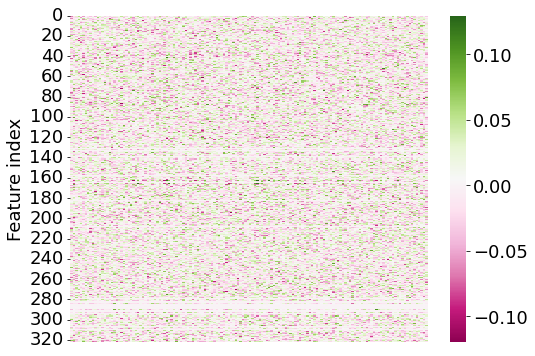

In [26]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight, cmap='PiYG')
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()

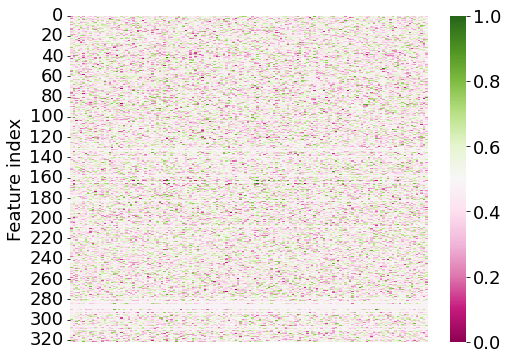

In [27]:
mn, mx = first_layer_weight.min(), first_layer_weight.max()
first_layer_weight_scaled = (first_layer_weight - mn) / (mx - mn)

fig, ax = plt.subplots(figsize = (8,6))
heatmp=sns.heatmap(first_layer_weight_scaled, cmap='PiYG', vmin=0, vmax=1)
cbar = heatmp.collections[0].colorbar
# here set the labelsize by 18
cbar.ax.tick_params(labelsize=18)
plt.xlabel('')
plt.xticks([])
plt.yticks(np.arange(0,np.array(column_names[:-2]).shape[0],20),np.arange(0,np.array(column_names[:-2]).shape[0],20),fontsize=18)
plt.ylabel('Feature index',fontsize=18)
plt.show()